# Subset

Description

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path

path = (
    Path
    .cwd()
    .parent
    .parent
    .joinpath('warbler.py')
)

os.chdir(path)
sys.path.append(path)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from constant import PICKLE, SETTINGS
from datatype.dataset import Dataset
from datatype.settings import Settings
from datatype.validation import (
    jaccard_coefficient, 
    rand_index,
    variation_of_information
)
from datatype.voronoi import Builder, VoronoiFCM
from fcmeans import FCM
from sklearn.metrics import (
    adjusted_rand_score, 
    jaccard_score,
    mutual_info_score,
    silhouette_score,
    rand_score
)
from textwrap import dedent

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
dataset = Dataset('segment')
dataframe = dataset.load()

In [5]:
dataframe[['filename', 'fcm_label_2d']].head(10)

,filename,fcm_label_2d
0,STE01_DbWY2017,1
1,STE01_DbWY2017,2
2,STE01_DbWY2017,1
3,STE01_DbWY2017,1
4,STE01_DbWY2017,8
5,STE01_DbWY2017,1
6,STE01_DbWY2017,1
7,STE01_DbWY2017,1
8,STE01_DbWY2017,8
9,STE01_DbWY2017,8


In [6]:
unique = dataframe.fcm_label_2d.unique()
unique.sort()

In [7]:
print(unique)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [8]:
size = [
    len(dataframe[dataframe.fcm_label_2d == label])
    for label in unique
]

In [9]:
minimum = min(size)
maximum = max(size)

print(minimum, maximum)

246 964


In [10]:
n = 200
small = []

for label in unique:
    filename = f"sample{label}"
    
    subset = dataframe[dataframe.fcm_label_2d == label]
    length = len(subset)

    print(f"{n} samples from a total of {length} for cluster {label}")
    
    sample = subset.sample(n=n)
    small.append(sample)

200 samples from a total of 947 for cluster 0
200 samples from a total of 964 for cluster 1
200 samples from a total of 619 for cluster 2
200 samples from a total of 816 for cluster 3
200 samples from a total of 735 for cluster 4
200 samples from a total of 805 for cluster 5
200 samples from a total of 810 for cluster 6
200 samples from a total of 246 for cluster 7
200 samples from a total of 488 for cluster 8
200 samples from a total of 584 for cluster 9
200 samples from a total of 896 for cluster 10
200 samples from a total of 535 for cluster 11
200 samples from a total of 707 for cluster 12
200 samples from a total of 789 for cluster 13
200 samples from a total of 652 for cluster 14
200 samples from a total of 660 for cluster 15
200 samples from a total of 617 for cluster 16
200 samples from a total of 558 for cluster 17
200 samples from a total of 764 for cluster 18


In [11]:
subset = pd.concat(small)

In [12]:
subset = subset.sort_index(ascending=True)

In [13]:
subset[['filename', 'fcm_label_2d']].head(10)

,filename,fcm_label_2d
4,STE01_DbWY2017,8
34,STE02a_DbWY2017,17
35,STE05_1_DbWY2017,6
37,STE05_1_DbWY2017,13
40,STE05_1_DbWY2017,2
43,STE05_1_DbWY2017,14
46,STE05_1_DbWY2017,16
49,STE05_1_DbWY2017,12
52,STE05_1_DbWY2017,4
56,STE05_DbWY2017,8


In [14]:
columns = {'fcm_label_2d': 'fcm_label_2d_original'}
subset.rename(columns=columns, inplace=True)

In [15]:
x = np.concatenate(
    (
        [subset.umap_x_2d],
        [subset.umap_y_2d]
    )
)

x = x.transpose()

In [16]:
fcm = FCM(
    m=1.5,
    max_iter=150,
    n_clusters=19
)

fcm.fit(x)

In [17]:
labels = fcm.predict(x)

In [18]:
labels

array([ 0,  3, 14, ..., 15, 15,  0], dtype=int64)

In [19]:
subset['fcm_label_2d_validation'] = labels

In [20]:
subset[['filename', 'fcm_label_2d_original', 'fcm_label_2d_validation']].head(10)

,filename,fcm_label_2d_original,fcm_label_2d_validation
4,STE01_DbWY2017,8,0
34,STE02a_DbWY2017,17,3
35,STE05_1_DbWY2017,6,14
37,STE05_1_DbWY2017,13,8
40,STE05_1_DbWY2017,2,0
43,STE05_1_DbWY2017,14,10
46,STE05_1_DbWY2017,16,5
49,STE05_1_DbWY2017,12,4
52,STE05_1_DbWY2017,4,16
56,STE05_DbWY2017,8,0


In [21]:
# dataset = Dataset('subset')
# dataset.save(subset)

In [22]:
comparison = subset['fcm_label_2d_original'] == subset['fcm_label_2d_validation']
length = len(comparison)

percentage = (comparison.sum() / length) * 100

In [23]:
percentage

2.5

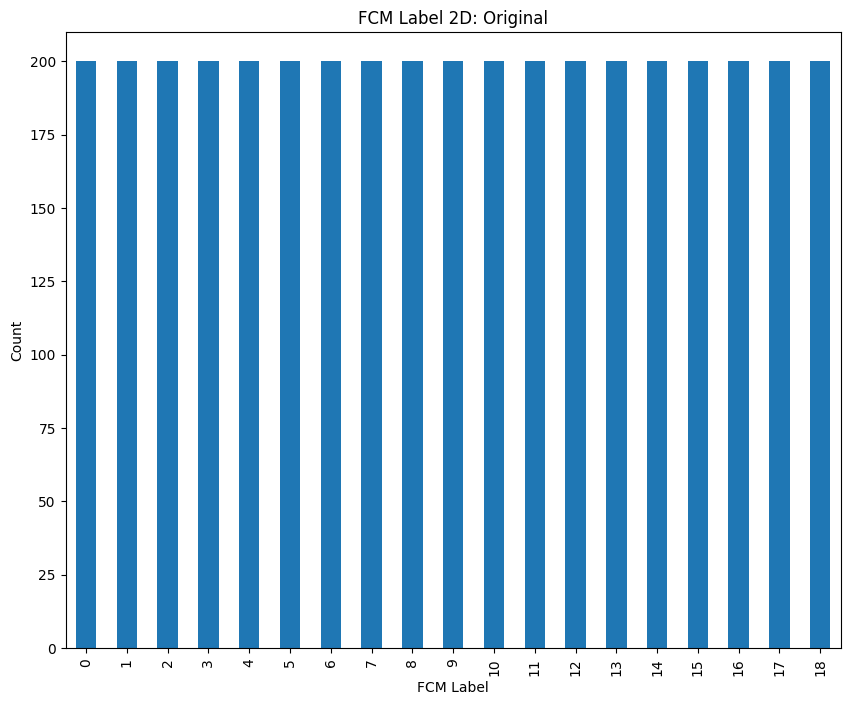

In [24]:
figsize = (10, 8)
fig, ax = plt.subplots(figsize=figsize)

subset['fcm_label_2d_original'].value_counts().sort_index().plot(ax=ax, kind='bar')

plt.xlabel('FCM Label')
plt.ylabel('Count')
plt.title('FCM Label 2D: Original')

plt.show()

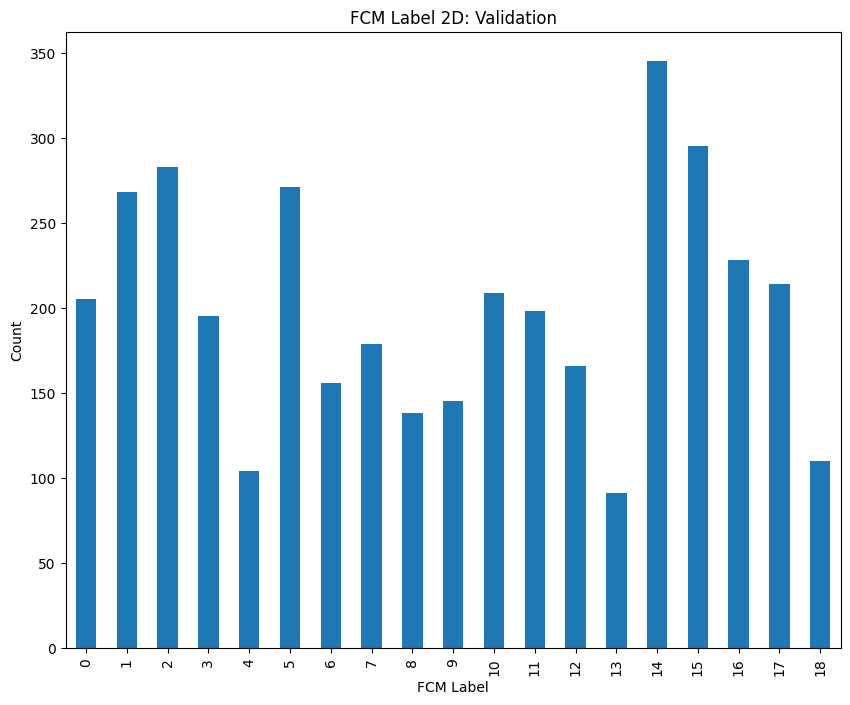

In [25]:
figsize = (10, 8)
fig, ax = plt.subplots(figsize=figsize)

subset['fcm_label_2d_validation'].value_counts().sort_index().plot(ax=ax, kind='bar')

plt.xlabel('FCM Label')
plt.ylabel('Count')
plt.title('FCM Label 2D: Validation')

plt.show()

In [26]:
truth = subset.fcm_label_2d_original.to_numpy()
prediction = subset.fcm_label_2d_validation.to_numpy()

In [27]:
print(truth[:10])

[ 1  1  8 10  6  6  0 16  0 17]


In [28]:
print(prediction[:10])

[ 9  6 17 15  6 17 10 15 10  0]


In [29]:
jc = jaccard_coefficient(truth, prediction)
jc

0.03923055396938188

In [30]:
jaccard_macro = jaccard_score(truth, prediction, average='macro')
jaccard_micro = jaccard_score(truth, prediction, average='micro')

print("Jaccard (macro):", jaccard_macro)
print("Jaccard (micro):", jaccard_micro)

Jaccard (macro): 0.019012084544545015
Jaccard (micro): 0.012658227848101266


In [38]:
mis = mutual_info_score(truth, prediction)
mis

2.4371857561038346

In [31]:
ari = adjusted_rand_score(truth, prediction)
ari

0.6646687436170479

In [32]:
ri = rand_index(truth, prediction)
ri

0.8143047712159268

In [33]:
ri = rand_score(truth, prediction)
ri

0.9648936700793838

In [35]:
ss = silhouette_score(
    np.reshape(truth, (-1, 1)), 
    np.reshape(prediction, (-1, 1))
)

ss

0.052262475350695496

In [ ]:
voi = variation_of_information(truth, prediction)
voi